In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm


sns.set(rc={'figure.figsize':(11.7,8.27)})

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install faraway

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 224 kB 8.8 MB/s 


In [ ]:
import faraway.datasets.punting
punting = faraway.datasets.punting.load()
punting.head()

,Distance,Hang,RStr,LStr,RFlex,LFlex,OStr
0,162.5,4.75,170,170,106,106,240.57
1,144.0,4.07,140,130,92,93,195.49
2,147.5,4.04,180,170,93,78,152.99
3,163.5,4.18,160,160,103,93,197.09
4,192.0,4.35,170,150,104,93,266.56


In [ ]:
print(faraway.datasets.punting.DESCR)


Leg strength and punting

Description:

     Investigators studied physical characteristics and ability in 13
     (American) football punters. Each volunteer punted a football ten
     times. The investigators recorded the average distance for the ten
     punts, in feet.

Variables:

     A data frame with 13 observations on the following 7 variables.

     ‘Distance’ average distance over 10 punts

     ‘Hang’ hang time

     ‘RStr’ right leg strength in pounds

     ‘LStr’ left leg strength in pounds

     ‘RFlex’ right hamstring muscle flexibility in degrees

     ‘LFlex’ left hamstring muscle flexibility in degrees

     ‘OStr’ overall leg strength in foot pounds

Source:

     Department of Health, Physical Education and Recreation at the Virginia Polytechnic Institute and State University, 1983.



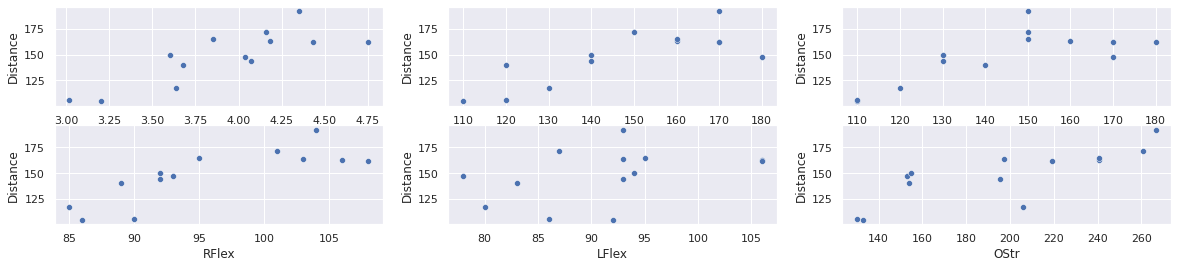

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 3)
fig.set_figwidth(20)

for i, col in enumerate(punting.columns[punting.columns != "Distance"].values):
    if i < 3:
        sns.scatterplot(x=col, y="Distance", data=punting, ax=ax1[i])
    else:
        sns.scatterplot(x=col, y="Distance", data=punting, ax=ax2[i-3])     

In [ ]:
punting.corr()["Distance"].sort_values(ascending=False)

Distance    1.000000
Hang        0.818854
RFlex       0.806334
OStr        0.796187
RStr        0.791467
LStr        0.744030
LFlex       0.407743
Name: Distance, dtype: float64

In [ ]:
import faraway.utils

lmod_s = smf.ols(
    "Distance ~ RFlex+ LFlex",
    data=punting
    ).fit()
lmod_s.sumary()

lmod_s.f_pvalue

            coefs stderr tvalues pvalues
Intercept -92.955 57.770   -1.61  0.1387
RFlex       3.337  0.807    4.13  0.0020
LFlex      -0.856  0.734   -1.17  0.2705

n=13 p=3 Residual SD=15.786 R-squared=0.69


0.0027682034145981704

Rejected $H_0: \beta_{RFLex}=\beta_{LFlex}$ at both $\alpha=0.05$ and $\alpha=0.01$</br></br>
Note that right flexibility is highly statistically significant here,</br> meaning that $H_0: \beta_{RFLex}=0$ is not rejected at both $\alpha=0.05$ and $\alpha=0.01$

</br></br>
Let's now add two leg-related variables:

In [ ]:
lmod = smf.ols(
    "Distance ~ RFlex+ LFlex + LStr + RStr",
    data=punting
    ).fit()
lmod.sumary()

            coefs stderr tvalues pvalues
Intercept -79.624 65.594   -1.21  0.2594
RFlex       2.375  1.437    1.65  0.1371
LFlex      -0.528  0.826   -0.64  0.5405
LStr       -0.186  0.513   -0.36  0.7260
RStr        0.512  0.486    1.05  0.3228

n=13 p=5 Residual SD=16.327 R-squared=0.74


No predictor is statistically significant at  α=0.05 now. </br>
$H_0: {\beta_{LFlex}} = {\beta_{RFlex}} = {\beta_{LStr}} = {\beta_{LStr}} = 0$ is rejected at $\alpha=0.05$:

In [ ]:
lmod.f_pvalue

0.01902481999841189

Moreover, testing $H_0: \beta_{RFLex}=\beta_{LFlex}$ gives:

In [ ]:
lmod_p = smf.ols(
    "Distance ~ LStr + RStr + I(RFlex + LFlex)",
    data=punting
    ).fit()
lmod_p.sumary()

sm.stats.anova_lm(lmod_p, lmod)

                   coefs stderr tvalues pvalues
Intercept        -44.262 63.528   -0.70  0.5036
LStr               0.015  0.517    0.03  0.9772
RStr               0.704  0.489    1.44  0.1839
I(RFlex + LFlex)   0.462  0.440    1.05  0.3209

n=13 p=4 Residual SD=17.154 R-squared=0.67


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,9.0,2648.358029,0.0,NaN,NaN,NaN
1,8.0,2132.640715,1.0,515.717315,1.934568,0.201723


That is, failed to reject.

Next: test $H_0: \beta_{LStr}=\beta_{Rstr} $ relative to the previous model. </br> 


In [ ]:
lmod_p = smf.ols(
    "Distance ~ I(LStr + RStr) + RFlex + LFlex",
    data=punting
    ).fit()
lmod_p.sumary()

sm.stats.anova_lm(lmod, lmod_p)

                 coefs stderr tvalues pvalues
Intercept      -71.269 63.145   -1.13  0.2882
I(LStr + RStr)   0.174  0.194    0.90  0.3928
RFlex            2.314  1.401    1.65  0.1331
LFlex           -0.577  0.804   -0.72  0.4908

n=13 p=4 Residual SD=15.942 R-squared=0.72


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,10.0,2973.072820,0.0,NaN,NaN,NaN
1,9.0,2287.355861,1.0,685.716959,2.698073,0.134885


Failed to reject at α=0.5

A reasonable test now: $H_0: \beta_{LStr}=\beta_{Rstr}  and  \beta_{RFLex}=\beta_{LFlex} $:

In [ ]:
lmod = smf.ols(
    "Distance ~ LStr + RStr + RFlex + LFlex",
    data=punting
    ).fit()
lmod.sumary()

lmod_p = smf.ols(
    "Distance ~ I(LStr + RStr) + I(RFlex + LFlex)",
    data=punting
    ).fit()
lmod_p.sumary()

sm.stats.anova_lm(lmod_p, lmod)

            coefs stderr tvalues pvalues
Intercept -79.624 65.594   -1.21  0.2594
LStr       -0.186  0.513   -0.36  0.7260
RStr        0.512  0.486    1.05  0.3228
RFlex       2.375  1.437    1.65  0.1371
LFlex      -0.528  0.826   -0.64  0.5405

n=13 p=5 Residual SD=16.327 R-squared=0.74
                   coefs stderr tvalues pvalues
Intercept        -36.153 60.965   -0.59  0.5663
I(LStr + RStr)     0.370  0.143    2.59  0.0270
I(RFlex + LFlex)   0.409  0.423    0.97  0.3559

n=13 p=3 Residual SD=16.730 R-squared=0.65


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,10.0,2799.074585,0.0,NaN,NaN,NaN
1,8.0,2132.640715,2.0,666.43387,1.249969,0.336987


Failed to reject. Note that the p-value here is bigger than for individual ones. </br>
That's natural: if we'd managed to reject any individual one, we'd automatically have rejected the joint one. </br> And the converse is not true.

Next lets include $OStr$ and test whether </br>
$H_0: \beta_{OStr} = \beta_{LStr} + \beta_{RStr}$

In [ ]:
lmod_t = smf.ols(
    "Distance ~ OStr+ I(LStr + RStr) + RFlex + LFlex",
    data=punting
    ).fit()
lmod_t.sumary()

lmod_t_p = smf.ols(
    "Distance ~ I(OStr+ I(LStr + RStr)) + RFlex + LFlex",
    data=punting
    ).fit()
lmod_t_p.sumary()

sm.stats.anova_lm(lmod_t_p, lmod_t)

                 coefs stderr tvalues pvalues
Intercept      -25.046 59.110   -0.42  0.6829
OStr             0.234  0.116    2.02  0.0780
I(LStr + RStr)   0.178  0.167    1.06  0.3192
RFlex            1.173  1.335    0.88  0.4051
LFlex           -0.402  0.699   -0.58  0.5805

n=13 p=5 Residual SD=13.760 R-squared=0.81
                           coefs stderr tvalues pvalues
Intercept                -23.837 55.844   -0.43  0.6795
I(OStr + I(LStr + RStr))   0.216  0.091    2.38  0.0412
RFlex                      1.036  1.174    0.88  0.4007
LFlex                     -0.355  0.642   -0.55  0.5940

n=13 p=4 Residual SD=13.035 R-squared=0.81


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,9.0,1529.273231,0.0,NaN,NaN,NaN
1,8.0,1514.714573,1.0,14.558658,0.076892,0.788585


Failed to reject.

Let's now change the prediction target to $Hang$

In [ ]:
lmod = smf.ols(
    "Hang ~ LStr + RStr + RFlex + LFlex",
    data=punting
    ).fit()
lmod.sumary()

           coefs stderr tvalues pvalues
Intercept -0.225  1.033   -0.22  0.8328
LStr       0.008  0.008    0.95  0.3685
RStr       0.005  0.008    0.67  0.5193
RFlex      0.019  0.023    0.86  0.4162
LFlex      0.005  0.013    0.35  0.7318

n=13 p=5 Residual SD=0.257 R-squared=0.82


It should be noted that once the target has changed, two models become uncompareable.